# init

In [ ]:

import torch
import numpy as np

# autograd

In [ ]:
class Value:
    """A simple class to represent a value in a computational graph for backpropagation."""

    def __init__(
        self,
        value: float,
        _children: tuple['Value', ...] = (),
        _op: str = '',
        label: str = '',
    ) -> None:
        """Initialize the Value with a numeric value."""

        self.value: float = value
        self._prev: set[Value] = set(_children)
        self.grad: float = 0.0
        self._op: str = _op
        self.label: str = label

        # magic trick
        self._backward = lambda: None

    def __repr__(self) -> str:
        """Return a string representation of the Value."""

        return f'Value(value={self.value:.5f},grad={self.grad:.5f},label=\'{self.label}\')'

    def __pow__(self, other: 'Value') -> 'Value':
        """Define exponentiation for Value objects."""

        # supports both Value and numeric exponentiation, addition to Karpathy's micrograd

        if not isinstance(other, Value):
            other = Value(other)

        res = Value(self.value ** other.value, _children = (self, other), _op = f'{self.label}^{other.label}')

        def _backward() -> None:
            # d/dx (x^y) = y * x^(y-1)
            # d/dy (x^y) = log(x) * x^y
            self.grad += other.value * (self.value ** (other.value - 1)) * res.grad
            if self.value > 0:
                other.grad += math.log(self.value) * res.value * res.grad
            else:
                other.grad += float('nan')  # log(x) is undefined for x <= 0
        res._backward = _backward

        return res

    def __rpow__(self, base: 'Value') -> 'Value':
        """Define reversed exponentiation for Value objects."""

        if not isinstance(base, Value):
            base = Value(base)

        return base ** self

    def __neg__(self) -> 'Value':
        """Define negation for Value objects."""

        return self * -1

    def __add__(self, other: 'Value') -> 'Value':
        """Define addition for Value objects."""

        if not isinstance(other, Value):
            other = Value(other)

        res = Value(self.value + other.value, _children = (self, other), _op = '+')

        def _backward() -> None:
            # d/dx (x + y) = 1
            # d/dy (x + y) = 1
            self.grad += 1.0 * res.grad
            other.grad += 1.0 * res.grad
        res._backward = _backward

        return res

    def __radd__(self, other: 'Value') -> 'Value':
        """Define right addition for Value objects."""

        # other + self
        return self + other

    def __sub__(self, other: 'Value') -> 'Value':
        """Define subtraction for Value objects."""

        return self + (-other)

    def __rsub__(self, other: 'Value') -> 'Value':
        """Define right subtraction for Value objects."""

        # other - self or -self + other
        return -self + other

    def __mul__(self, other: 'Value') -> 'Value':
        """Define multiplication for Value objects."""

        if not isinstance(other, Value):
            other = Value(other)

        res = Value(self.value * other.value, _children = (self, other), _op = '*')

        def _backward() -> None:
            # d/dx (x * y) = y + x * d/dx(y)
            # d/dy (x * y) = x + y * d/dy(x)
            self.grad += other.value * res.grad
            other.grad += self.value * res.grad
        res._backward = _backward

        return res

    def __rmul__(self, other: 'Value') -> 'Value':
        """Define right multiplication for Value objects."""

        # other * self
        return self * other

    def __truediv__(self, other: 'Value') -> 'Value':
        """Define division for Value objects."""

        return self * (other ** (-1))

    def __rtruediv__(self, other: 'Value') -> 'Value':
        """Define right division for Value objects."""

        # other / self or other * (self ** -1)
        return other * (self ** -1)

    def relu(self) -> 'Value':
        """Define the ReLU activation function for Value objects."""

        x: float = self.value
        r: float = max(0.0, x)
        res = Value(r, _children = (self,), _op = 'relu', label = 'ReLU')

        def _backward() -> None:
            self.grad += (1.0 if x > 0 else 0.0) * res.grad
        res._backward = _backward

        return res

    def leaky_relu(self, alpha: float = 0.01) -> 'Value':
        """Define the Leaky ReLU activation function for Value objects."""

        x: float = self.value
        r: float = x if x > 0 else alpha * x
        res = Value(r, _children = (self,), _op = 'leaky_relu', label = 'Leaky ReLU')

        def _backward() -> None:
            self.grad += (1.0 if x > 0 else alpha) * res.grad
        res._backward = _backward

        return res

    def log(self) -> 'Value':
        """Define the natural logarithm for Value objects."""

        x: float = self.value
        if x <= 0:
            raise ValueError("Logarithm undefined for non-positive values.")

        l: float = math.log(x)
        res = Value(l, _children = (self,), _op = 'log', label = 'log')

        def _backward() -> None:
            self.grad += (1.0 / x) * res.grad
        res._backward = _backward

        return res

    def exp(self) -> 'Value':
        """Define the exponential function for Value objects."""

        x: float = self.value
        e: float = math.exp(x)
        res = Value(e, _children = (self,), _op = 'exp', label = 'exp')

        def _backward() -> None:
            self.grad += e * res.grad
        res._backward = _backward

        return res

    def tanh(self) -> 'Value':
        """Define the hyperbolic tangent function for Value objects."""

        x: float = self.value
        t: float = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        res = Value(t, _children = (self,), _op = 'tanh', label = 'tanh')

        def _backward() -> None:
            self.grad += (1.0 - t ** 2) * res.grad
        res._backward = _backward

        return res

    def trace(self) -> tuple[set['Value'], set['Value']]:
        """Trace the computational graph starting from the root Value."""

        nodes: set[Value] = set()
        edges: set[Value] = set()
        def dfs(value: Value) -> None:
            """Depth-first search to traverse the graph."""

            if value not in nodes:
                nodes.add(value)

                for child in value._prev:
                    edges.add((child, value))
                    dfs(child)

        dfs(self)

        return nodes, edges

    def topo_sort(self) -> list['Value']:
        """Perform a topological sort of the computational graph."""

        nodes, _ = self.trace()
        sorted_nodes: list[Value] = []

        def dfs(node: Value) -> None:
            """Visit each node in the graph."""

            if node not in sorted_nodes:
                for child in node._prev:
                    dfs(child)
                sorted_nodes.append(node)

        for node in nodes:
            dfs(node)

        return sorted_nodes

    def backward(self) -> None:
        """Perform backpropagation to compute gradients."""
        self.grad = 1.0

        topo_order = self.topo_sort()
        for node in reversed(topo_order):
            node._backward()

    def draw_graph(self) -> Digraph:
        """Visualize the computational graph using Graphviz."""

        """Draw the computational graph using the trace function."""

        nodes, edges = self.trace()

        dot = Digraph(format = 'svg', graph_attr = {'rankdir': 'LR'})

        for node in nodes:
            uid: str = str(id(node))

            dot.node(name = uid, label = f'{node.label} | data: {node.value:.4f} | grad: {node.grad:.4f}', shape = 'record')

            if (len(node._op) > 0):
                dot.node(name = uid + node._op, label = node._op, shape = 'circle')
                dot.edge(uid + node._op, uid)

        for node1, node2 in edges:
            dot.edge(str(id(node1)), str(id(node2)) + node2._op)

        return dot

In [3]:
a = Value(5)
b = Value(-3)

print(-a)
print(a + b)
print(a - b)
print(b - a)
print(a * b)
print(a / b)
print(b / a)
print(a / 2)
print(2 / a)

Value(value=-5.00000,grad=0.00000,label='')
Value(value=2.00000,grad=0.00000,label='')
Value(value=8.00000,grad=0.00000,label='')
Value(value=-8.00000,grad=0.00000,label='')
Value(value=-15.00000,grad=0.00000,label='')
Value(value=-1.66667,grad=0.00000,label='')
Value(value=-0.60000,grad=0.00000,label='')
Value(value=2.50000,grad=0.00000,label='')
Value(value=0.40000,grad=0.00000,label='')


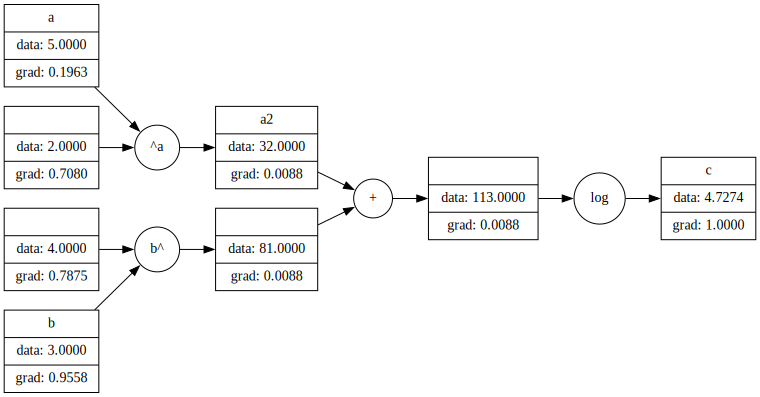

In [4]:
a = Value(5, label = 'a')
b = Value(3, label = 'b')
a2 = 2 ** a; a2.label = 'a2'
b4 = b ** 4
c = (a2 + b4).log()
c.label = 'c'

c.backward()

c.draw_graph()

In [5]:
a = Value(5, label = 'a')
b = Value(-3, label = 'b')
c = Value(2, label = 'c')
e = a + b; e.label = 'e'
d = a * b + c; d.label = 'd'
f = e + c; f.label = 'f'
L = d * f; L.label = 'L'

print(L)

Value(value=-52.00000,grad=0.00000,label='L')


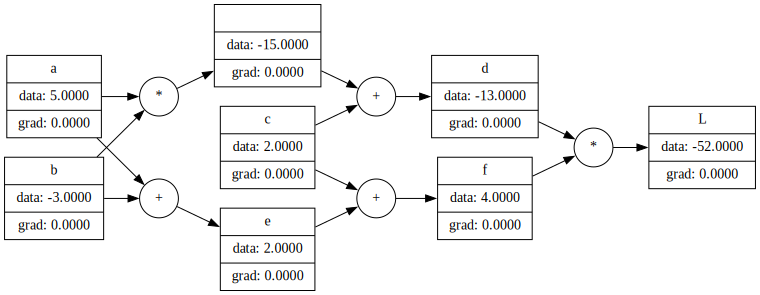

In [6]:
def trace(root: Value) -> tuple[set[Value], set[Value]]:
    """Trace the computational graph starting from the root Value."""

    nodes: set[Value] = set()
    edges: set[Value] = set()
    def dfs(value: Value) -> None:
        """Depth-first search to traverse the graph."""

        if value not in nodes:
            nodes.add(value)

            for child in value._prev:
                edges.add((child, value))
                dfs(child)

    dfs(root)

    return nodes, edges

def draw_graph(root: Value) -> Digraph:
    """Draw the computational graph using the trace function."""

    nodes, edges = trace(root)

    dot = Digraph(format = 'svg', graph_attr = {'rankdir': 'LR'})

    for node in nodes:
        uid: str = str(id(node))

        dot.node(name = uid, label = f'{node.label} | data: {node.value:.4f} | grad: {node.grad:.4f}', shape = 'record')

        if (len(node._op) > 0):
            dot.node(name = uid + node._op, label = node._op, shape = 'circle')
            dot.edge(uid + node._op, uid)

    for node1, node2 in edges:
        dot.edge(str(id(node1)), str(id(node2)) + node2._op)

    return dot

def topo_sort(root: Value) -> list[Value]:
    """Perform a topological sort of the computational graph."""

    nodes, _ = trace(root)
    sorted_nodes: list[Value] = []

    def dfs(node: Value) -> None:
        """Visit each node in the graph."""

        if node not in sorted_nodes:
            for child in node._prev:
                dfs(child)
            sorted_nodes.append(node)

    for node in nodes:
        dfs(node)

    return sorted_nodes

draw_graph(L)

In [7]:
L.grad = 1.0
d.grad = 4.0
f.grad = -13.0
c.grad = -9
e.grad = -13.0

In [8]:
def test() -> None:
    """Run a simple test to verify the functionality of the Value class."""

    h: float = 0.001

    a = Value(5, label = 'a')
    b = Value(-3, label = 'b')
    c = Value(2, label = 'c')
    e = a + b; e.label = 'e'
    d = a * b + c; d.label = 'd'
    f = e + c; f.label = 'f'
    L = d * f; L.label = 'L'
    L1: float = L.value


    a = Value(5, label = 'a')
    b = Value(-3, label = 'b')
    c = Value(2, label = 'c')
    e = a + b; e.label = 'e'
    e.value += h
    d = a * b + c; d.label = 'd'
    f = e + c; f.label = 'f'
    L = d * f; L.label = 'L'
    L2: float = L.value

    print((L2 - L1) / h)

test()

-12.999999999991019


In [9]:
def test2() -> None:
    h: float = 0.00001

    x1 = Value(2.0, label = 'x1')
    x2 = Value(0.0, label = 'x2')
    w1 = Value(-3, label = 'w1')
    w2 = Value(1, label = 'w2')
    b = Value(5.123081724, label = 'b')

    x1w1 = x1 * w1; x1w1.label = 'x1w1'
    x2w2 = x2 * w2; x2w2.label = 'x2w2'
    x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

    model = x1w1x2w2 + b; model.label = 'model'
    o = model.tanh(); o.label = 'o'
    L1 = o.value

    x1 = Value(2.0, label = 'x1')
    x2 = Value(0.0, label = 'x2')
    w1 = Value(-3, label = 'w1')
    w2 = Value(1, label = 'w2')
    b = Value(5.123081724, label = 'b')

    x1w1 = x1 * w1; x1w1.label = 'x1w1'
    x2w2 = x2 * w2; x2w2.label = 'x2w2'
    x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

    model = x1w1x2w2 + b; model.label = 'model'
    model.value += h
    o = model.tanh(); o.label = 'o'
    L2 = o.value

    print((L2 - L1) / h)

test2()

0.5031588687476329


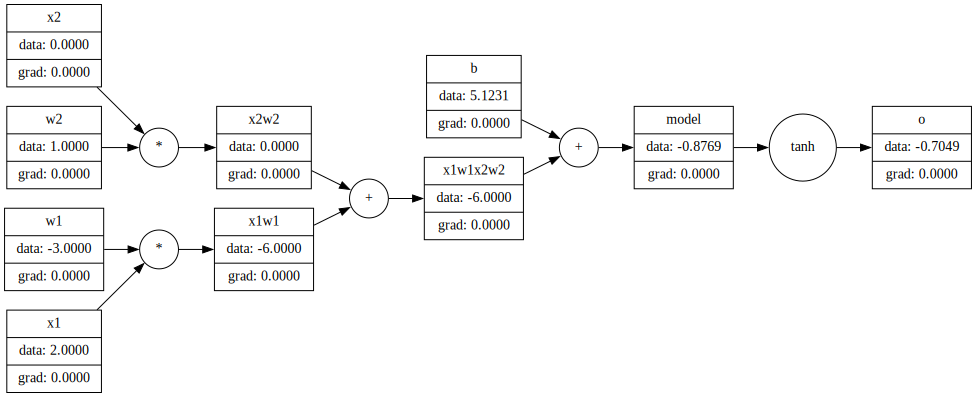

In [10]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
w1 = Value(-3, label = 'w1')
w2 = Value(1, label = 'w2')
b = Value(5.123081724, label = 'b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

model = x1w1x2w2 + b; model.label = 'model'

o = model.tanh(); o.label = 'o'

# o.grad = 1.0
# model.grad = 1.0 - o.value ** 2
# b.grad = model.grad # dmodel/db = 1.0
# x1w1x2w2.grad = model.grad
# x1w1.grad = 1.0 * x1w1x2w2.grad
# x2w2.grad = 1.0 * x1w1x2w2.grad
# x1.grad = x1w1.grad * w1.value
# w1.grad = x1w1.grad * x1.value
# x2.grad = x2w2.grad * w2.value
# w2.grad = x2w2.grad * x2.value

# o.grad = 1.0
# o._backward()
# model._backward()
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()

draw_graph(o)

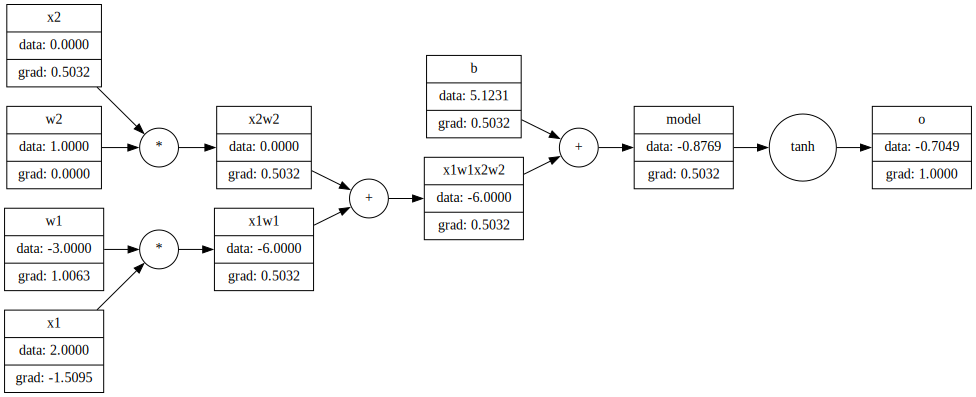

In [11]:
o.backward()
draw_graph(o)

In [12]:
topo_order = topo_sort(o)

topo_order

[Value(value=-3.00000,grad=1.00631,label='w1'),
 Value(value=2.00000,grad=-1.50947,label='x1'),
 Value(value=-6.00000,grad=0.50316,label='x1w1'),
 Value(value=0.00000,grad=0.50316,label='x2'),
 Value(value=1.00000,grad=0.00000,label='w2'),
 Value(value=0.00000,grad=0.50316,label='x2w2'),
 Value(value=-6.00000,grad=0.50316,label='x1w1x2w2'),
 Value(value=5.12308,grad=0.50316,label='b'),
 Value(value=-0.87692,grad=0.50316,label='model'),
 Value(value=-0.70487,grad=1.00000,label='o')]

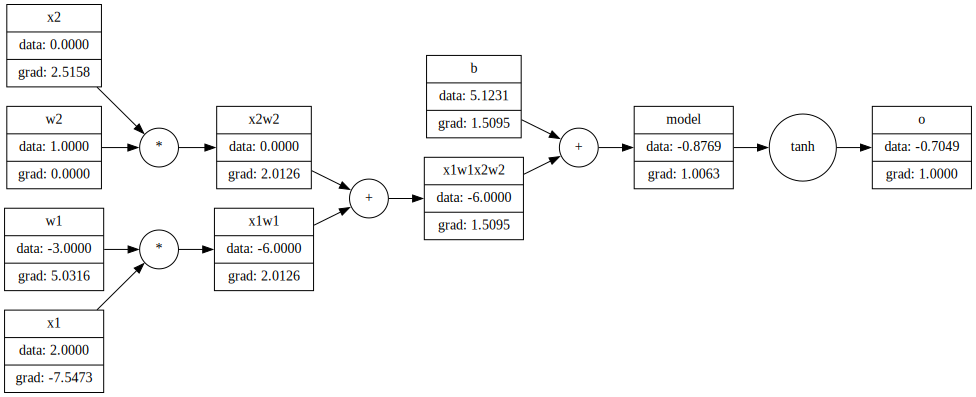

In [13]:
# base case, last node, do/do = 1
o.grad = 1.0

for node in reversed(topo_order):
    node._backward()

draw_graph(o)

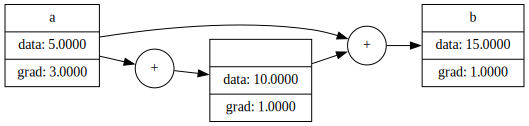

In [14]:
a = Value(5, label = 'a')
b = a + a + a; b.label = 'b'

b.backward()

draw_graph(b)

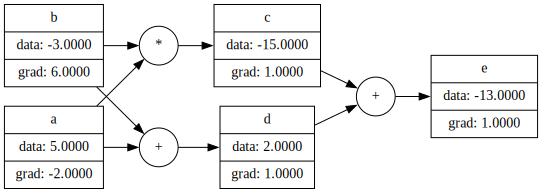

In [15]:
a = Value(5, label = 'a')
b = Value(-3, label = 'b')
c = a * b; c.label = 'c'
d = a + b; d.label = 'd'
e = c + d; e.label = 'e'

e.backward()

draw_graph(e)

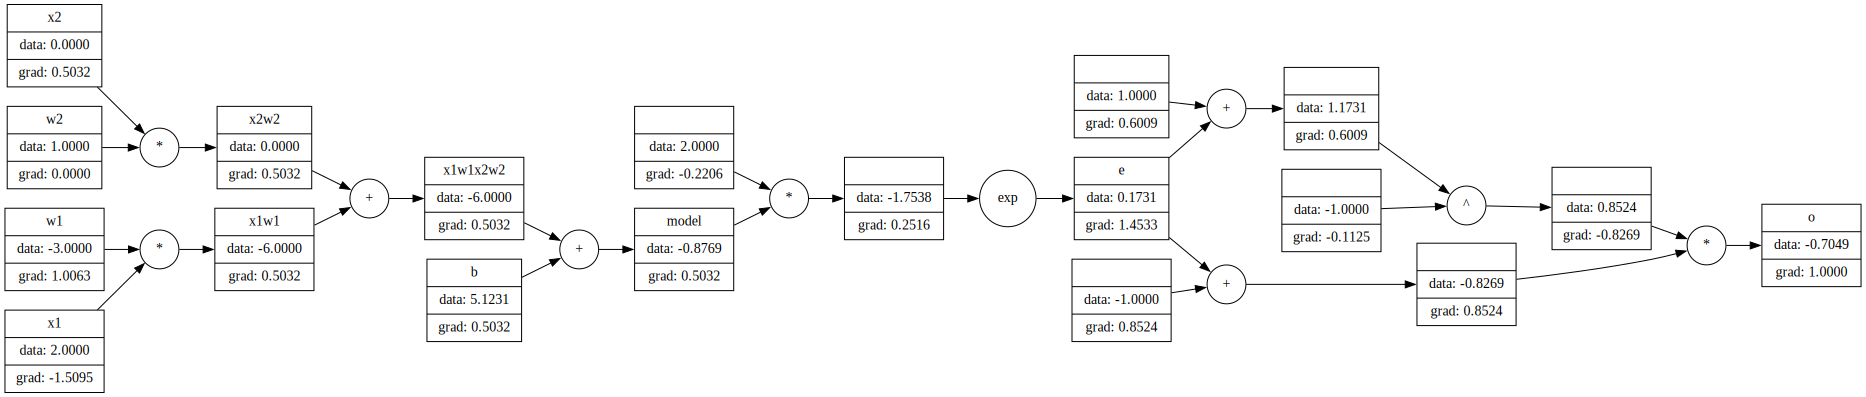

In [16]:
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
w1 = Value(-3, label = 'w1')
w2 = Value(1, label = 'w2')
b = Value(5.123081724, label = 'b')

x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'

model = x1w1x2w2 + b; model.label = 'model'

e = (2 * model).exp(); e.label = 'e'
o = (e - 1) / (e + 1)
o.label = 'o'

o.backward()

draw_graph(o)

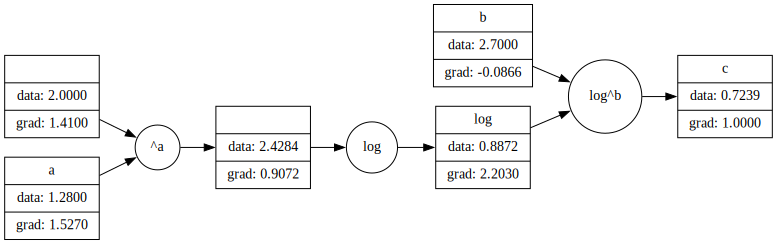

In [17]:
a = Value(1.28, label = 'a')
b = Value(2.7, label = 'b')
c = (2 ** a).log() ** b
c.label = 'c'

c.backward()

draw_graph(c)

In [ ]:
at = torch.tensor(1.28, requires_grad = True)
bt = torch.tensor(2.7, requires_grad = True)
ct: torch.Tensor = 2 ** at
ct = ct.log() ** bt
ct.backward()

ct.item() - c.value, at.grad - a.grad, bt.grad - b.grad

(-2.9077938723531815e-08, tensor(-1.1921e-07), tensor(-1.4901e-08))

# neural network

In [38]:
rng = np.random.default_rng()
rng.uniform(-1, 1)

0.23680329076175832

In [156]:
class Neuron:
    """A simple neuron class to demonstrate the functionality of the Value class."""

    def __init__(self, num_inputs: int) -> None:
        """Initialize the neuron with weights and bias."""

        self.w = [Value(rng.uniform(-1, 1), label = f'w{i}') for i in range(num_inputs)]
        self.b = Value(rng.uniform(-1, 1), label='b')

    def __call__(self, x: list[Value]) -> Value:
        """Forward pass through the neuron."""

        activations: list[Value] = [x_i * w_i for x_i, w_i in zip(x, self.w, strict = True)]
        y: Value = sum(activations, start = self.b)  # sum the weighted inputs and bias
        y = y.tanh()  # activation function
        y.label = 'y'

        return y

    def parameters(self) -> list[Value]:
        """Return the parameters of the neuron (weights and bias)."""

        return [*self.w, self.b]

class Layer:
    """A simple layer class to demonstrate the functionality of the Neuron class."""

    def __init__(self, num_inputs: int, num_neurons: int) -> None:
        """Initialize the layer with a list of neurons."""

        self.neurons = [Neuron(num_inputs) for _ in range(num_neurons)]

    def __call__(self, x: list[Value]) -> list[Value]:
        """Forward pass through the layer."""

        y: list[Value] = [neuron(x) for neuron in self.neurons]

        return y if len(y) > 1 else y[0]  # return a single Value if there's only one neuron

    def parameters(self) -> list[Value]:
        """Return the parameters of the layer (weights and biases of all neurons)."""

        return [param for neuron in self.neurons for param in neuron.parameters()]

class MLP:
    """A simple multi-layer perceptron class to demonstrate the functionality of the Layer class."""

    def __init__(self, num_inputs: int, num_outputs: list[int]) -> None:
        """Initialize the MLP with an input layer, hidden layer, and output layer."""

        sz = [num_inputs, * num_outputs] # size of each layer, first is input size, last is output size
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(num_outputs))]

    def __call__(self, x: list[Value]) -> list[Value]:
        """Forward pass through the MLP."""

        y = x
        for layer in self.layers:
            y = layer(y)

        return y

    def parameters(self) -> list[Value]:
        """Return the parameters of the MLP (weights and biases of all layers)."""

        return [param for layer in self.layers for param in layer.parameters()]

In [351]:
x = [2, 3, 4]
model = MLP(3, [4, 4, 1])
y = model(x)
print(y)
# y.draw_graph()

xs: list[float] = [
    [2.0, 3.0, 4.0],
    [1.0, 2.0, 3.0],
    [0.0, 1.0, 2.0],
    [1.0, 0.0, -1.0],
]

ys: list[float] = [
    1.0,
    -1.0,
    -1.0,
    1.0,
]

Value(value=-0.13525,grad=0.00000,label='y')


In [343]:
y_preds: list[Value] = [model(x) for x in xs]
se_loss = [(y_pred - y_true) ** 2 for y_pred, y_true in zip(y_preds, ys, strict = True)]
se_loss = sum(se_loss)
se_loss

Value(value=0.09549,grad=0.00000,label='')

In [ ]:
se_loss.backward()

learning_rate: float = 0.001

for param in model.parameters():
    param.value += -learning_rate * param.grad
    param.grad = 0.0  # reset gradients after updating parameters

model.parameters()

[Value(value=-1.24021,grad=6.20100,label='w0'),
 Value(value=0.51012,grad=1.32716,label='w1'),
 Value(value=-0.38773,grad=-3.54667,label='w2'),
 Value(value=-0.22306,grad=-5.35883,label='b'),
 Value(value=0.35558,grad=2.05744,label='w0'),
 Value(value=0.34024,grad=-3.83932,label='w1'),
 Value(value=0.88686,grad=-9.73607,label='w2'),
 Value(value=-0.52871,grad=-0.00599,label='b'),
 Value(value=1.11265,grad=-20.18782,label='w0'),
 Value(value=0.68978,grad=14.70174,label='w1'),
 Value(value=-1.01698,grad=49.59131,label='w2'),
 Value(value=0.25465,grad=33.06160,label='b'),
 Value(value=-0.28104,grad=-0.26711,label='w0'),
 Value(value=0.82223,grad=0.17748,label='w1'),
 Value(value=0.91439,grad=0.62206,label='w2'),
 Value(value=-0.86530,grad=-0.08190,label='b'),
 Value(value=-0.16144,grad=1.11595,label='w0'),
 Value(value=0.42610,grad=5.38364,label='w1'),
 Value(value=0.72725,grad=-2.93034,label='w2'),
 Value(value=0.01794,grad=7.10356,label='w3'),
 Value(value=-0.07680,grad=0.81722,label='b

In [355]:
# training loop

for epoch in range(1000):
    y_preds: list[Value] = [model(x) for x in xs]
    se_loss = [(y_pred - y_true) ** 2 for y_pred, y_true in zip(y_preds, ys, strict = True)]
    se_loss = sum(se_loss)

    se_loss.backward()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {se_loss.value:.4f}')

    for param in model.parameters():
        param.value += -learning_rate * param.grad
        param.grad = 0.0  # reset gradients after updating parameters

Epoch 0, Loss: 0.0367
Epoch 100, Loss: 0.0342
Epoch 200, Loss: 0.0319
Epoch 300, Loss: 0.0299
Epoch 400, Loss: 0.0281
Epoch 500, Loss: 0.0265
Epoch 600, Loss: 0.0251
Epoch 700, Loss: 0.0238
Epoch 800, Loss: 0.0226
Epoch 900, Loss: 0.0215


In [357]:
model.parameters()

[Value(value=-1.29650,grad=0.00000,label='w0'),
 Value(value=-0.82839,grad=0.00000,label='w1'),
 Value(value=1.17194,grad=0.00000,label='w2'),
 Value(value=-0.08401,grad=0.00000,label='b'),
 Value(value=-0.53752,grad=0.00000,label='w0'),
 Value(value=-0.45597,grad=0.00000,label='w1'),
 Value(value=-0.97075,grad=0.00000,label='w2'),
 Value(value=0.92376,grad=0.00000,label='b'),
 Value(value=0.63686,grad=0.00000,label='w0'),
 Value(value=0.03120,grad=0.00000,label='w1'),
 Value(value=-0.29613,grad=0.00000,label='w2'),
 Value(value=0.40426,grad=0.00000,label='b'),
 Value(value=-0.55709,grad=0.00000,label='w0'),
 Value(value=0.37233,grad=0.00000,label='w1'),
 Value(value=0.45590,grad=0.00000,label='w2'),
 Value(value=0.61913,grad=0.00000,label='b'),
 Value(value=0.41362,grad=0.00000,label='w0'),
 Value(value=0.11607,grad=0.00000,label='w1'),
 Value(value=0.57934,grad=0.00000,label='w2'),
 Value(value=0.04652,grad=0.00000,label='w3'),
 Value(value=0.92785,grad=0.00000,label='b'),
 Value(val